<a href="https://colab.research.google.com/github/Siagnos/RHCnet/blob/main/Examples/model_loading_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!git clone https://github.com/Siagnos/RHCnet.git
%cd RHCnet/Examples
%pip install tensorflow==2.15.* tensorflow-addons==0.23.0

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pickle

import tensorflow as tf
from tensorflow.keras.models import load_model
# Make sure to install tensorflow-addons if RectifiedAdam is needed
# !pip install tensorflow-addons
# from tensorflow_addons.optimizers import RectifiedAdam # Keep this commented unless RectifiedAdam is truly needed and installed


import sys
import os # Import the os module

# Print current working directory to check relative paths
print(f"Current working directory: {os.getcwd()}")
# List contents of the parent directory to confirm existence of Utils and Models folders
print("Contents of parent directory:")
!ls .. # Check the output of this command to see if 'Utils' is listed

# *** Update the paths below with the correct paths to your Utils and Models directories ***
# Example: If Utils and Models are in the same directory as your notebook:
# sys.path.append('./Utils')
# sys.path.append('./Models')

# Add the directory containing 'Utils' and 'Models' to sys.path
# This assumes 'Utils' and 'Models' are directly within the parent directory
parent_dir = os.path.abspath('../')
sys.path.append(parent_dir)

# Check if the directories were added to sys.path
print(f"sys.path after append: {sys.path}")

# Construct the full path to the network_tools.py file
# Assuming network_tools.py is in a subdirectory named 'Utils' within the parent_dir
network_tools_path = os.path.join(parent_dir, 'Utils', 'network_tools.py')
print(f"Checking for file: {network_tools_path}")

# Ensure that the file exists before attempting import
if not os.path.exists(network_tools_path):
    print(f"Error: The file '{network_tools_path}' was not found.")
    print("Please ensure the 'Utils' directory is one level up from this notebook")
    print("and contains 'network_tools.py', or update the sys.path.append() call.")
    # Optionally, you could exit or raise an error here if the file is critical
    # sys.exit("Required file not found.")
else:
    # If the file is found at the expected path, attempt the import
    # Note: We need to import from the module *within* the Utils directory
    # Adding the parent directory allows us to import 'Utils.network_tools'
    # However, the original code imports '*'. Let's stick to the original import style,
    # which requires the directory *containing* the module to be in sys.path.
    # The original `sys.path.append('../Utils')` is more appropriate for `from network_tools import *`.
    # Let's revert to the original path logic but ensure the file check is correct for that logic.

    # Correcting the sys.path append to add the directory *containing* the modules
    # Remove the parent_dir append and add the specific module directories
    try:
        sys.path.remove(parent_dir) # Remove if it was added in a previous run
    except ValueError:
        pass # Ignore if not found

    # This adds the 'Utils' directory itself to sys.path
    sys.path.append('../Utils')
    # This adds the 'Models' directory itself to sys.path
    sys.path.append('../Models')

    print(f"sys.path after correcting appends: {sys.path}")

    # Re-check the network_tools_path based on the new sys.path logic for clarity
    # The import will search in the directories listed in sys.path
    network_tools_path_check = os.path.abspath('../Utils/network_tools.py')
    print(f"Re-checking expected file location based on sys.path: {network_tools_path_check}")

    if os.path.exists(network_tools_path_check):
        print(f"Found '{network_tools_path_check}'. Proceeding with import.")
        # Re-add the imports once you are sure the path is correct and the file exists
        from network_tools import *
        from hnet import *
        print("Modules 'network_tools' and 'hnet' imported successfully.")
    else:
        print(f"Error: Still could not find '{network_tools_path_check}' after adding '../Utils' to sys.path.")
        print("Please double-check your notebook's current working directory and the location of your 'Utils' folder.")
        # You might want to raise an error here to stop execution if the import is essential
        # raise FileNotFoundError(f"Required module file not found at {network_tools_path_check}")


%pylab inline

# path to the pre-trained model
PRE_TRAINED_MODEL_PATH = '../SavedModels/ecg_supervised_416.h5'

Cloning into 'RHCnet'...
remote: Enumerating objects: 262, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 262 (delta 32), reused 41 (delta 12), pack-reused 184 (from 1)
Receiving objects: 100% (262/262), 176.73 MiB | 28.99 MiB/s, done.
Resolving deltas: 100% (108/108), done.
/content/RHCnet/Examples/RHCnet/Examples/RHCnet/Examples/RHCnet/Examples/RHCnet/Examples/RHCnet/Examples/RHCnet/Examples/RHCnet/Examples/RHCnet/Examples
Current working directory: /content/RHCnet/Examples/RHCnet/Examples/RHCnet/Examples/RHCnet/Examples/RHCnet/Examples/RHCnet/Examples/RHCnet/Examples/RHCnet/Examples/RHCnet/Examples
Contents of parent directory:
Examples  LICENSE  Models  pkg_list.txt  README.md  SavedModels  Utils
sys.path after append: ['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/

# RHCnet: Model loading demonstration
The notebook shows the simple procedure by which one can load, train, and do inference with RHCnet.

The lead order is: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

## Example ECG

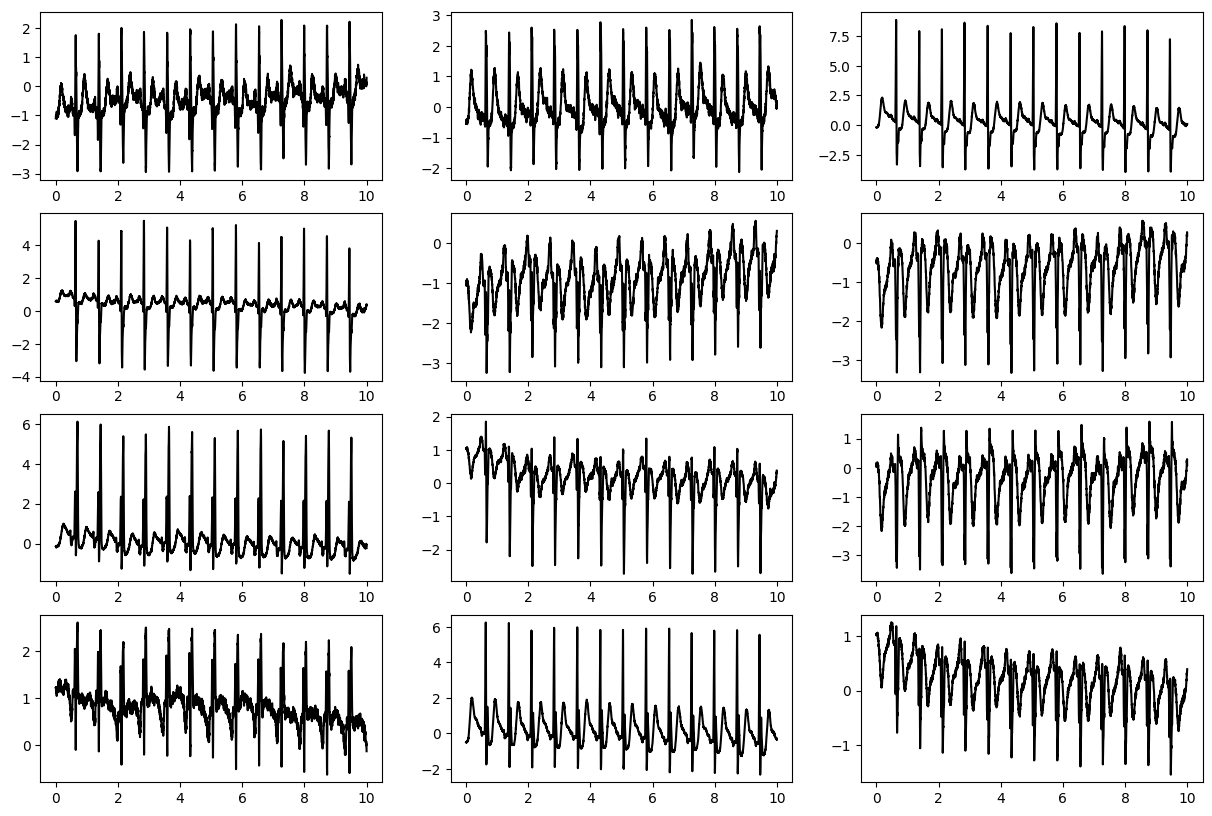

In [37]:
# load the file
ecg_ex = pd.read_csv('samples.csv')

# a bit of processing
ecg_array = np.array(ecg_ex[ecg_ex.columns[1:13]].iloc[1:,:].astype(float))

# downsample to 500 Hz, to get the right shape
ecg_array = ecg_array[::2,:]
time = np.linspace(0,10,5000)

# an input ECG is normalized by the mean and variance of all the samples in that ECG
ecg_array -= np.mean(ecg_array)
ecg_array /= np.std(ecg_array)

# plot the normalized ECGs
figs, axs = plt.subplots(4,3,figsize=[15,10])
for i in range(12) :
    axs[i%4,i%3].plot(time,ecg_array[:,i], 'k')

## Instantiate and training RHCnet
e.g. if you would like to start with our pre-trained model, then tune with your own data

In [38]:
# load the pre-trained model using function in Utils/network_tools.py
pre_trained_model = load_pretrained_model()

# take the model up to the latent layer
latent = tf.keras.Model(pre_trained_model.inputs, pre_trained_model.get_layer('embed').output)

# append the additional layers to the pre-trained layers which project to the latent space
full_model = AppendNet(latent)
full_model.build((None,5000,12))

In [39]:
########## DATA ###########
'''
For the purposes of this demonstration, we generate random inputs and labels.
The actual, pressure-matched training data will be de-identified and released
when possible.
'''

N = 100

X_train = np.random.rand(N,5000,12)
y_train = np.random.rand(N,4) > 0.5

In [40]:
##### TRAIN THE MODEL #####
#   as much as you want   #
#     or not at all       #

optimizer = tf.keras.optimizers.Adam() # can modify LR, of course
loss_fn = tf.keras.losses.BinaryCrossentropy()
epochs = 1

'''
Note: We wrote our own training loop so we could freely modify the procedure.
Feel free to do so (https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)
'''

full_model.compile(optimizer, loss_fn)
full_model.fit(X_train, y_train, epochs=epochs)

4/4 [==============================] - 11s 931ms/step - loss: 0.8252


In [41]:
# Now, we can do inference at will

X_test = np.random.rand(100,5000,12)
y_pred = full_model.predict(X_test)

4/4 [==============================] - 1s 187ms/step


## Load the trained RHCnet
Here, we load the model that we trained on all of our data.

Due to an issue with tensorflow related to loading operations with custom gradents, we use our own function to load the weights.

In [42]:
trained_model = make_final_net()

In [43]:
# we get an output with shape 1x4 for our example ECG, as desired
sample_out = trained_model.predict(ecg_array[np.newaxis,...])[0]
print(sample_out)

1/1 [==============================] - 1s 512ms/step
[0.93741715 0.996271   0.9916603  0.99922806]


## Unreliability

We can now compute the unreliablity score,

<center>$U = |p_{pred}(mPAP > 20 \mbox{ mmHg}) - p(PH)|$</center>

where

<center>$p(PH) = p_{pred}(PCWP > 15 \mbox{ mmHg}) + p_{pred}(PVR > 3 \mbox{ Wood's Units}) - p_{pred}(PCWP > 15 \mbox{ mmHg})\cdot p_{pred}(PVR > 3 \mbox{ Wood's Units})$</center>



In [44]:
p_PH = sample_out[1] + sample_out[2] - sample_out[1] * sample_out[2]

U = np.abs(sample_out[0] - p_PH)

print("The unreliablity score is %.3f" % U)

The unreliablity score is 0.063
